In [37]:
# Original file name: tis.ipynb from Rare Event Summer School in Dropbox
# Written by: Steven Hall 
# Modified by: PH Minh
# Last Updated: 03-17-2023

## TIS Tutorial


- This code will perform transition interface sampling (TIS) on a simple potential energy surface (PES). 

- The code is constructed as follows: 

    - Choosing your PES

    - Deciding on your simulation settings

    - Run equilibration and basin simulation 

    - Generate an initial path at a higher temperature

    - Perform TIS on your selected PES at your desired temperature
        
    - Visualize the paths for each interface ensemble

    - Calculate rate for the event (A --> B)

        - Calculate flux through the first interface

        - Calculate and visualize the crossing probability (for each interface and cumulative)

## Learning Objectives

1. Understand what a transition interface sampling (TIS) is.  

    - How is TIS different from TPS?  
    </br>

2. Explore the importance of interface placement and interface type on a given potential energy surface (PES).
    * To do this exploration, you can modify the following variables in the code:

        - **pes_type**: this will change the PES that you use for your simulation 

        - **op_type**: this will change the form of your op. The options provided are op_type = x, y, or x+y

        - **interfaces values** in the interface list: this will change where you place your interface

        - **basinA; basinB**: this will change where you define your basin(s) on the PES

        - **init_coords**: this will change where you start on your PES in your simulation

        - **beta**: this will change the temperature since beta = 1/(k_B*T), which consequently also changes the PES barrier height due to the change in temperature (T)

    * Questions to think about while exploring: 

        - How does changing variables related to the PES/my system (like pes_type, beta, basinA, basinB) impact my sampling?
        
        - How does changing variables related to TIS methodology (like op_type, interfaces values, init_coords) impact my sampling?

3. Understand the procedure in TIS sampling and the reason behind these steps that we follow for performing a RETIS "simulation".

    - Why do we need to run an intial simulation at a higher temperature?


## Plot potential energy surface contours

PES-1: $$ Equation $$
PES-2: $$ Equation $$
PES-3: $$ Equation $$
PES-4: $$ Equation $$


## 1
<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-1.png"> 

## 2
<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-2.png"> 

## 3
<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-3.png">

## 4
<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-4.png">

## Choose your PES

In [ ]:
import numpy as np
import sys
import math
import copy
from math import exp
import langevin_dynamics as ld
import random
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm

# Select your PES type: ***** EDIT HERE *****
pes_type = 1

if pes_type == 4:
    # Plot potential energy surface contours
    N = 100
    x_vec = np.linspace(-2, 0.5, N)
    y_vec = np.linspace(0, 2, N)
    X, Y = np.meshgrid(x_vec, y_vec)
    energy = np.zeros((N, N))
    
    # Plot contours
    for i in range(len(x_vec)):
        for j in range(len(y_vec)):
            energy[j][i] = ld.potential(x_vec[i],y_vec[j],pes_type)
    plt.contour(x_vec,y_vec,energy,np.linspace(-100,100,30), cmap = 'jet')
    cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
    cbar.set_ticks([])
    cbar.set_label(label = 'Energy', size=12)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show

else:
    # Plot potential energy surface contours
    N = 100
    x_vec = np.linspace(-3.5, 3.5, N)
    y_vec = np.linspace(-3.5, 3.5, N)
    X, Y = np.meshgrid(x_vec, y_vec)
    energy = np.zeros((N, N))

    # Plot contours
    for i in range(len(x_vec)):
        for j in range(len(y_vec)):
            energy[j][i] = ld.potential(x_vec[i],y_vec[j],pes_type)
    plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')
    cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
    cbar.set_ticks([])
    cbar.set_label(label = 'Energy', size=12)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show

## Simulation Settings

<function matplotlib.pyplot.show(close=None, block=None)>

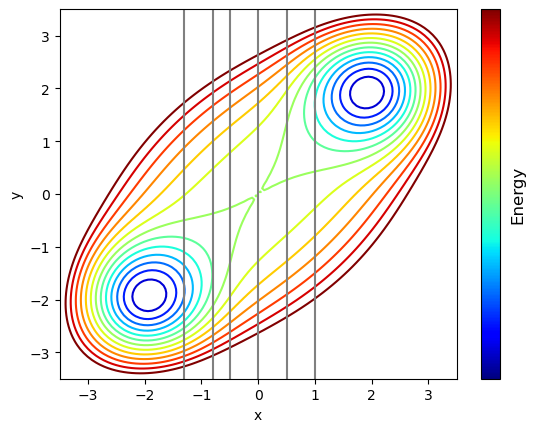

In [39]:
# TIS settings
n_moves = 1000              # number of moves to perform for each path ensemble - path ensemble corresponding to each diff interface
n_discard = 50              # number of moves to discard at the beginning of RETIS - we do this to decorrelate new paths from old paths
op_type = 1                 # order parameter;  1:x  2:y  3:x+y
interfaces = [-1.3, -0.8, -0.5, 0.0, 0.5, 1.0, 2.0]
basinA = -2.09              # boundary of basin A; must be less than the first interface
basinB = interfaces[-1]     # basin B defined as last interface
init_coords = [-1, -1]      # initial coordinates
init_p = [0, 0]             # initial momenta
basineqlen = 5000           # basin equilibration length (steps)
basinlen = 50000            # basin simulation length
sigma = 0.5                 # standard deviation of momenta perturbation

#Langevin dynamics settings
beta = 2.5                  # 1/kT
gamma = 5.0                 # friction
dt = 0.01                   # time step size



# Plot PES contours with interfaces
# Plot contours
for i in range(len(x_vec)):
    for j in range(len(y_vec)):
        energy[j][i] = ld.potential(x_vec[i],y_vec[j],pes_type)

if pes_type == 4:
    plt.contour(x_vec,y_vec,energy,np.linspace(-100,100,30), cmap = 'jet')
else:   
    plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')

# Plot interfaces
for i in range(len(interfaces)-1):
    plt.plot(np.linspace(interfaces[i],interfaces[i],10),np.linspace(min(y_vec),max(y_vec),10), color='grey')

cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
cbar.set_ticks([])
cbar.set_label(label = 'Energy', size=12)
plt.xlabel('x')
plt.ylabel('y')
plt.show

## Equilibration Run

In [40]:
# Declare array to store basin trajectory
basintraj = np.zeros((basinlen + 1, 6),dtype=float)                             # matrix: each row is the next configuration and each column is x, y, px, py, fx, fy

# Calculate initial forces
fx,fy = ld.force(init_coords[0],init_coords[1],init_p[0],init_p[1],dt,beta,gamma,pes_type)

# Combine positions, momenta, and forces to make an initial phase point
init_phasepoint = init_coords + init_p + [fx,fy]
basintrajeq = ld.vv_step(init_phasepoint,dt,beta,gamma,pes_type)                # use velocity verlet to generate the next configuration of x, y, px, py, fx, fy

# Equilibrate in basin
for i in range(1,basineqlen + 1):
    new_basintrajeq = ld.vv_step(basintrajeq,dt,beta,gamma,pes_type)            # array of x, y, px, py, fx, fy
    basintrajeq = new_basintrajeq
    op = ld.calc_op(op_type,basintrajeq[0],basintrajeq[1])                      #ld.calc_op(op_type, x, y of the trajectory)
    # check if trajectory reaches basin B
    if op >= basinB:
        sys.exit("Basin trajectory reached B! Exiting...")


In [41]:
# Visualizing equilibration 

# for i in range(len(x_vec)):
#     for j in range(len(y_vec)):
#         energy[j][i] = ld.potential(x_vec[i],y_vec[j],pes_type)

# if pes_type == 4:
#     plt.contour(x_vec,y_vec,energy,np.linspace(-100,100,30), cmap = 'jet')
# else:   
#     plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')

# plt.scatter(basintraj[:,0],basintraj[:,1]) 

# cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
# cbar.set_ticks([])
# cbar.set_label(label = 'Energy', size=12)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show


## Run a basin simulation

- Why do we need to run basin simulation?

**[Answer: Edit Text]**

<function matplotlib.pyplot.show(close=None, block=None)>

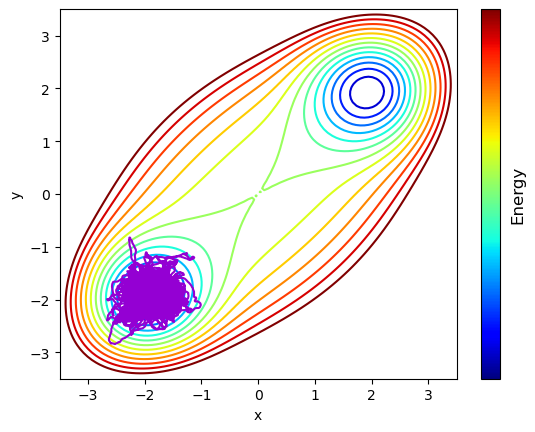

In [42]:
basintraj[0] = basintrajeq                                                      # saving the last configuration from the equilibration run as the first config for prod run
fromBasin = False
n_cross_flux = 0

# Run one basin A simulation and check for first crossings
for j in range(1,basinlen + 1):
    basintraj[j] = ld.vv_step(basintraj[j-1],dt,beta,gamma,pes_type)            # each iteration is a configuration so that basintraj at the end makes a matrix
    op = ld.calc_op(op_type,basintraj[j][0],basintraj[j][1]) 
    
    if op < basinA:
        fromBasin = True
    
    if fromBasin == True and op >= interfaces[0]: 
        n_cross_flux += 1
        fromBasin = False
    
    # Check if trajectory reaches basin B
    if op >= basinB:
        sys.exit("Basin trajectory reached B! Exiting...")

if n_cross_flux == 0:
    sys.exit("No first crossings obtained from basin A to interface 0. Exiting...")


# Visualizing basin simulation 

for i in range(len(x_vec)):
    for j in range(len(y_vec)):
        energy[j][i] = ld.potential(x_vec[i],y_vec[j],pes_type)

if pes_type == 4:
    plt.contour(x_vec,y_vec,energy,np.linspace(-100,100,30), cmap = 'jet')
else:   
    plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')

plt.plot(basintraj[:,0],basintraj[:,1],color='darkviolet') 

cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
cbar.set_ticks([])
cbar.set_label(label = 'Energy', size=12)
plt.xlabel('x')
plt.ylabel('y')
plt.show


## Generate the initial paths by simulating at a higher temperature

- Why do we need to generate an initial path at a higher temperature? **Bonus**: How do we control the temperature? 

**[Answer: Edit Text]**

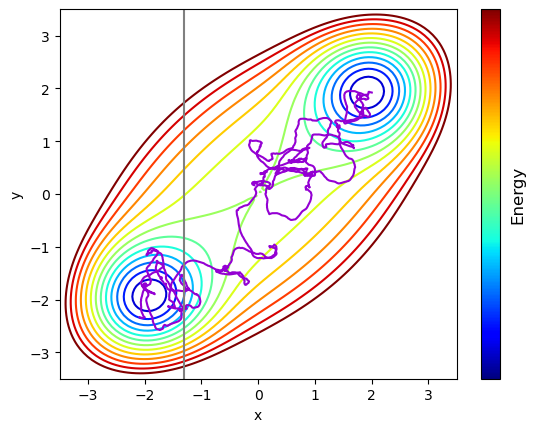

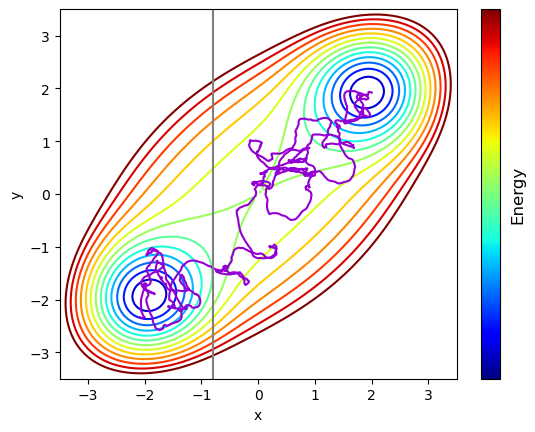

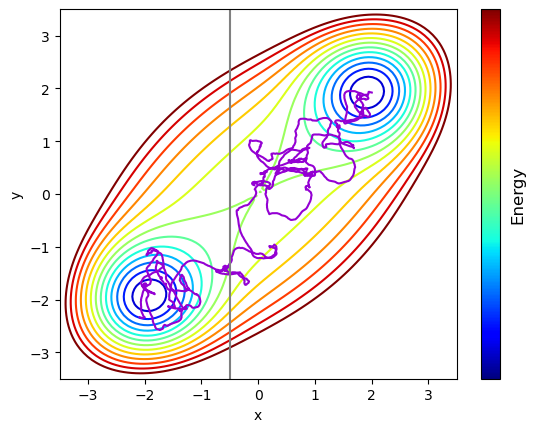

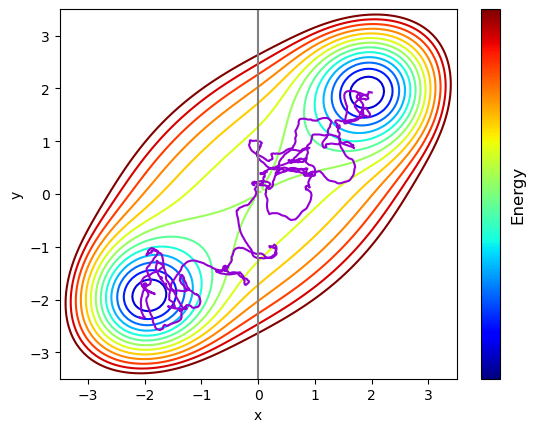

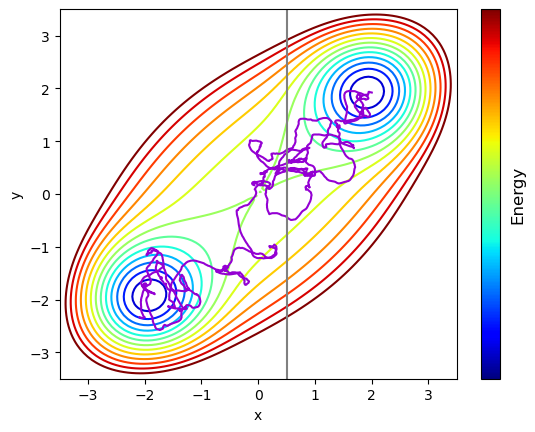

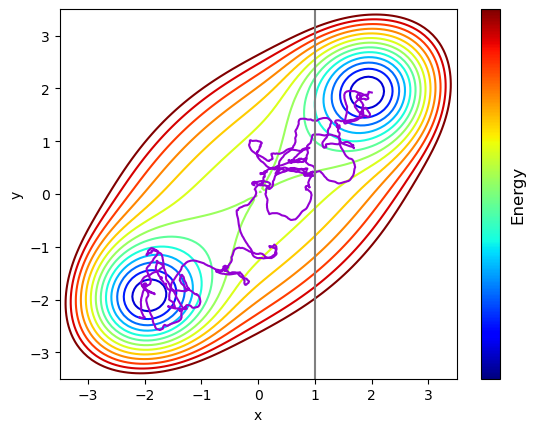

In [43]:
# Run at higher temperature to generate an initial path
initpath = []
beta_initpath = 1.5                                                     # this controls the temperature because beta = 1/kb*T
fromBasin = False

# Use init_phasepoint to start trajectory
trajstep = ld.vv_step(init_phasepoint,dt,beta_initpath,gamma,pes_type)  # array of x, y, px, py, fx, fy to get the first config to generate a path
op = ld.calc_op(op_type,trajstep[0],trajstep[1])                        # calculate the op to see where this config is at, in A or pass A and cross some lambda, or in B?

while op < basinB:                                                      # as long as it is not in B
    nextstep = ld.vv_step(trajstep,dt,beta_initpath,gamma,pes_type)              # generate next config
    trajstep = nextstep                                                 # save this config to trajstep, so we could shoot from it again 
    op = ld.calc_op(op_type,trajstep[0],trajstep[1])

    if op < basinA:                                                     # if this then this traj is from basin A 
        fromBasin = True
        initpath = []                                                   # reset path if it returns to A - do this until it's about to leave the basin
        trajstep = np.append(trajstep,[op],axis=0)                      # array of x, y, px, py, fx, fy and op value
        initpath.append(trajstep) 
        continue

    if op >= basinA and fromBasin == True:                              # now that you have left basin A, we'll save the different configs to the list initpath
        trajstep = np.append(trajstep,[op],axis=0)
        initpath.append(trajstep)
        continue

initpath = np.asarray(initpath)                                         # this gives all configurations of this 1 initial path
allpaths = [[] for i in range(len(interfaces)-1)]                       # list of empty lists of size len(interfaces)-1, each empty list is a placeholder for paths in 1 interface 
acc = np.zeros(len(interfaces)-1)
n_cross = np.zeros(len(interfaces)-1)

for i in range(len(interfaces)-1):                                      # loop over amt of interface starting from 0 
    allpaths[i].append(initpath)    


# Visualize initial paths for each interface

for i in range(len(interfaces) - 1):
    plt.figure()
    
    if pes_type == 4:
        plt.contour(x_vec,y_vec,energy,np.linspace(-100,100,30), cmap = 'jet')
    else:   
        plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')
    
    for j in range(0,len(allpaths[i])):
        plt.plot(allpaths[i][j][:,0],allpaths[i][j][:,1],color='darkviolet')               # allpaths[i] tells you the interface ensemble you're in, 
                                                                                           # [j] tells you a specific path in that ensemble, [:,0/1] 
                                                                                           # takes all the x/y values of the paths in i
    
    plt.plot(np.linspace(interfaces[i],interfaces[i],10),np.linspace(min(y_vec),max(y_vec),10), color='grey')
    
    cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
    cbar.set_ticks([])
    cbar.set_label(label = 'Energy', size=12)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show 

## Perform TIS

In [44]:
for move in range(1, n_moves):
    for i in range(len(interfaces)-1):
        path = allpaths[i][move-1]
        reject_move = False
        lmax = round((len(path) + 1)/np.random.uniform())
        
        # Pick random shooting point
        index = np.random.randint(len(path) - 2) + 1                        # minus 2 to avoid basinA and i+1 points
        
        # Perturb the momenta
        shoot_point = copy.deepcopy(path[index])
        shoot_point[2] += np.random.normal(0,sigma)
        shoot_point[3] += np.random.normal(0,sigma)
        trial_path = np.asarray([shoot_point])
        if exp(-beta*(ld.kinetic_energy(shoot_point) - ld.kinetic_energy(path[index]))) < np.random.uniform():
            reject_move = True
        
        # Integrate backwards path if we have not rejected the move...
        if reject_move == False:

            path_length = 1
            trial_path[:,2] *=-1
            trial_path[:,3] *=-1
            trajstep = copy.deepcopy(trial_path[-1])
            op = ld.calc_op(op_type,trajstep[0],trajstep[1])
            
            while op >= basinA:

                trajstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)
                op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                trajstep = np.append(trajstep,[op],axis=0)
                trial_path = np.append(trial_path,[trajstep],axis=0)
                path_length +=1
                
                # Reject if the maximum path length is exceeded
                if path_length > lmax:
                    reject_move = True
                    break

                # Reject if the backward path segment goes to B
                if op >= basinB:
                    reject_move = True
                    break
        
        # Forward shooting             
        if reject_move == False: 
            trial_path = np.flip(trial_path,axis=0)                             # flip it from the back to front of this trial path (because it was shooting backwards), 
                                                                                # so we flip so that the last config we extract from here will be where we'll use to shoot forward
            trial_path[:,2] *=-1
            trial_path[:,3] *=-1
            trajstep = copy.deepcopy(trial_path[-1])
            op = ld.calc_op(op_type,trajstep[0],trajstep[1])
    
            while op >= basinA and op < basinB:                                 # this is so that it restricts forward shooting to either end in A or B

                nextstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)
                trajstep = nextstep
                op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                trajstep = np.append(trajstep,[op],axis=0)
                trial_path = np.append(trial_path,[trajstep],axis=0)
                path_length +=1
                
                if path_length > lmax:
                    reject_move = True
                    break

        # Final chance to reject a path (because no crossing of interface i)
        if np.where(trial_path[:,6]>interfaces[i])[0].shape[0] == 0:
            reject_move = True
        
        # If we DON'T reject, then path becomes trial path
        if reject_move == False:
            path = trial_path
            acc[i] += 1
        
        # Here we count the crosses, ignoring all paths before move 50
        if move > n_discard:
            if np.where(path[:,6]>interfaces[i+1])[0].shape[0] > 0:
                n_cross[i] += 1
        allpaths[i].append(path)


## Plot the paths collected at each interface

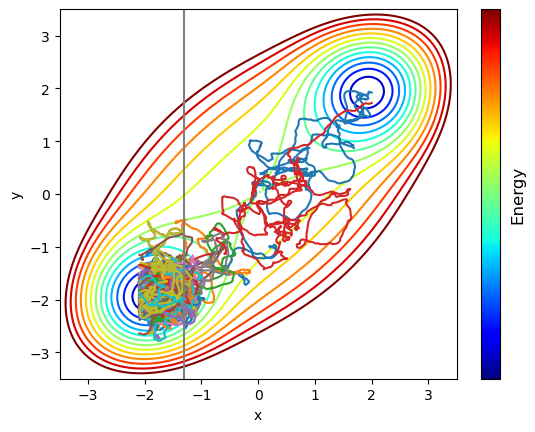

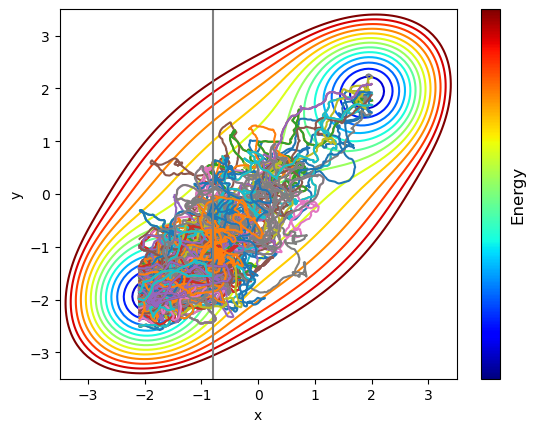

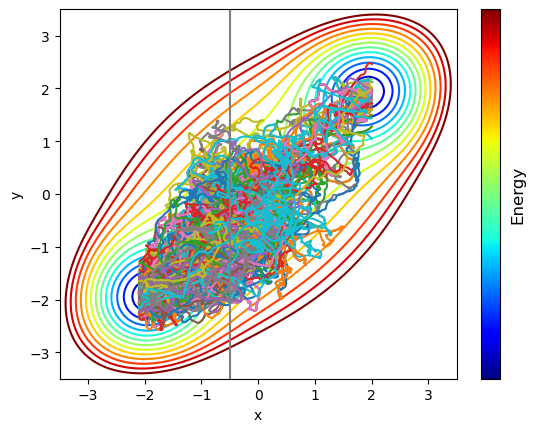

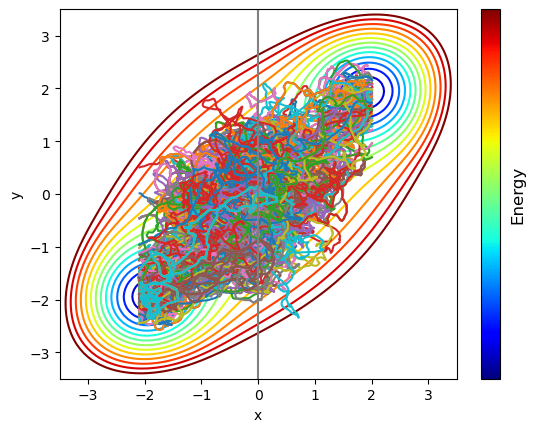

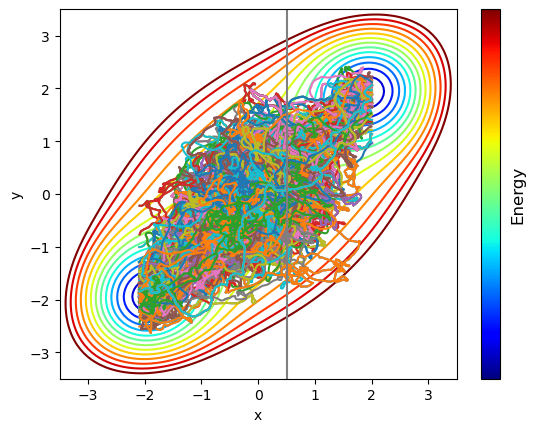

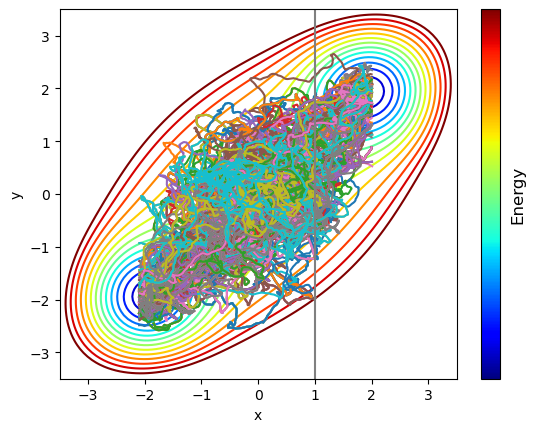

In [45]:
# Plot sampled paths from each interface
skip = 5

for i in range(len(interfaces) - 1):
    plt.figure()
    
    if pes_type == 4:
        plt.contour(x_vec,y_vec,energy,np.linspace(-100,100,30), cmap = 'jet')
    else:   
        plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')

    for j in range(1,len(allpaths[i]),skip):
        plt.plot(allpaths[i][j][:,0],allpaths[i][j][:,1]) # allpaths[i] tells you the interface ensemble you're in, [j] tells you a specific path in that ensemble, [:,0/1] takes all the x/y values of the paths in i
    plt.plot(np.linspace(interfaces[i],interfaces[i],10),np.linspace(min(y_vec),max(y_vec),10), color='grey')
    cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
    cbar.set_ticks([])
    cbar.set_label(label = 'Energy', size=12)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show
    

## Calculate the flux, acceptance probabilities, crossing probabilities and rate

- Equations: 
    - $$ Rate $$
    - $$ Crossing Probability $$
    - $$ Flux $$
    - $$ Acceptance Probability $$

In [46]:
# Calculate flux

flux = n_cross_flux/(basinlen*dt)
print("Flux through first interface: {}\n".format(flux))
print("Number of first crossings: {}\n".format(n_cross_flux))

# Calculate Acceptance and Crossing Probability 
cross_probs = []

for i in range(len(interfaces)-1):
    cross_prob = n_cross[i]/(len(allpaths[i]) - n_discard)
    cross_probs.append(cross_prob)
    print("Interface %d acceptance prob: %f" % (i, acc[i]/n_moves))

rate = flux*np.prod(np.asarray(cross_probs))  # flux from the first crossing * product of crossing probability of all interface
print("Crossing probabilities: {}".format(cross_probs))
print("Rate: {}".format(rate))



Flux through first interface: 0.014

Number of first crossings: 7

Interface 0 acceptance prob: 0.114000
Interface 1 acceptance prob: 0.104000
Interface 2 acceptance prob: 0.122000
Interface 3 acceptance prob: 0.142000
Interface 4 acceptance prob: 0.109000
Interface 5 acceptance prob: 0.091000
Crossing probabilities: [0.004210526315789474, 0.3263157894736842, 0.38421052631578945, 0.6063157894736843, 0.7957894736842105, 0.8905263157894737]
Rate: 3.1755254340538248e-06


## Plot Cumulative Crossing Probability from A to B

<function matplotlib.pyplot.show(close=None, block=None)>

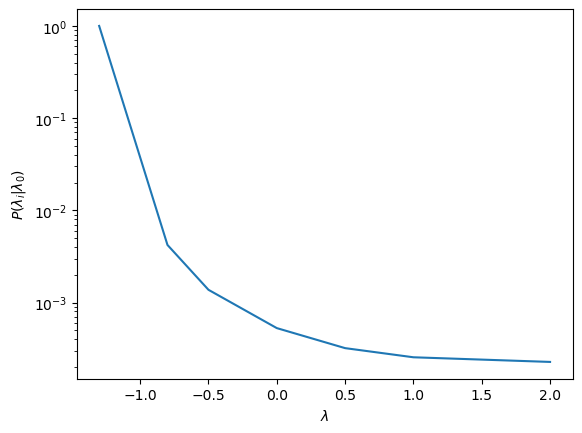

In [47]:
# Plot cumulative crossing probability
cumuprob = []
for i in range(len(cross_probs)+1):
    cumuprob.append(np.prod(np.asarray(cross_probs[:i])))       # np.asarray(cross_probs[:i]) takes the cross_prob array up until interface i
                                                                # cumuprob[0] then is the probability to cross lambda 0, cumuprob[1] then is the probability to cross lambda 0 AND 1
probs = plt.figure(2)
plt.plot(interfaces,cumuprob)
plt.yscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('$P(\lambda_i|\lambda_0)$')
plt.show

## Calculate the crossing probability at finer intervals of the order parameter

<function matplotlib.pyplot.show(close=None, block=None)>

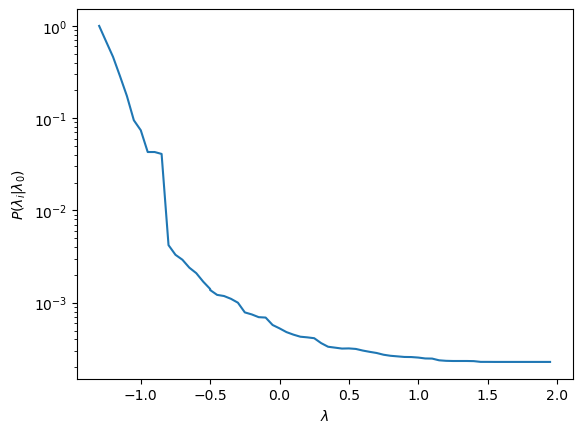

In [48]:
# Plot the crossing probability of lambda at every 0.1 interval instead of at each interface
cumuprob = []
for i in range(len(interfaces)-1):
    for opval in np.arange(interfaces[i], interfaces[i+1], 0.05):
        count = 0
        for path in allpaths[i]:
            if len(np.where(path[:,6] > opval)[0]) > 0: # if there's a path whose op value is higher than the interface it's crossing then, we consider that the path cross that interface
                count += 1
        op_prob = count/(len(allpaths[i])) # for each i, this is calculating the number of crossing of that interface / total number of paths in that interface ensemble
        op_cumuprob = np.prod(np.asarray(cross_probs[:i]))*op_prob
        cumuprob.append([opval, op_cumuprob])
        
cumuprob = np.asarray(cumuprob)
        
probs = plt.figure(2)
plt.plot(cumuprob[:,0],cumuprob[:,1])
plt.yscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('$P(\lambda_i|\lambda_0)$')
plt.show